In [1]:
import wandb
wandb.login()  # Opens a browser once to authenticate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import datasets, transforms
from torchvision.models import resnet50
from itertools import product
import numpy as np
import random
import copy
import os, ssl, zipfile, urllib
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from sklearn.metrics import confusion_matrix
import seaborn as sns



wandb: Currently logged in as: analiju (analiju-paris) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:

LOCAL_OR_COLAB = "LOCAL"
SEED           = 42
NUM_EPOCHS     = 10
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1

# hyperparameter grid
# BATCH_SIZES = [64, 128, 256]
BATCH_SIZES = [32, 64]  # Using a single batch size for simplicity
LRS = [1e-4, 3e-4]

GRID        = [
    (3.75e-4, 0.5  ),
]

BETAS=(0.9,0.98)
EPS=1e-8, 

if LOCAL_OR_COLAB == "LOCAL":
    DATA_DIR = "/users/c/carvalhj/datasets/EuroSAT_RGB/"
else:
    data_root = "/content/EuroSAT_RGB"
    zip_path  = "/content/EuroSAT.zip"
    if not os.path.exists(data_root):
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(
            "https://madm.dfki.de/files/sentinel/EuroSAT.zip", zip_path
        )
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall("/content")
        os.rename("/content/2750", data_root)
    DATA_DIR = data_root

NUM_WORKERS = 4 

In [3]:

def compute_mean_std(dataset, batch_size):
    loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    n_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)  # (B, C, H*W)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples
    return mean.tolist(), std.tolist()

def get_data_loaders(data_dir, batch_size):

    base_tf = transforms.ToTensor()
    ds_all = datasets.ImageFolder(root=data_dir, transform=base_tf)
    labels = np.array(ds_all.targets)   # numpy array of shape (N,)
    num_classes = len(ds_all.classes)
    total_count = len(ds_all)
    print(f"Total samples in folder: {total_count}, classes: {ds_all.classes}")

    train_idx, val_idx, test_idx = get_split_indexes(labels, total_count)

    train_subset_for_stats = Subset(ds_all, train_idx)
    mean, std = compute_mean_std(train_subset_for_stats, batch_size)
    print(f"Computed mean: {mean}")
    print(f"Computed std:  {std}")

    tf_final = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    #  full ImageFolder but now with normalization baked in
    ds_all_norm = datasets.ImageFolder(root=data_dir, transform=tf_final)

    train_ds = Subset(ds_all_norm, train_idx)
    val_ds   = Subset(ds_all_norm, val_idx)
    test_ds  = Subset(ds_all_norm, test_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, generator=torch.Generator().manual_seed(SEED))

    # calculate class proportions
    prop_train = get_proportion(num_classes, train_ds)
    prop_val   = get_proportion(num_classes, val_ds)
    prop_test  = get_proportion(num_classes, test_ds)
    # plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test)
    print(f"Train/Val/Test splits: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

    return train_loader, val_loader, test_loader, num_classes

def get_proportion(num_classes, dataset):
    return np.bincount(np.array(dataset.dataset.targets)[dataset.indices], minlength=num_classes) / len(dataset)

def get_split_indexes(labels, total_count):
    n_train = int(np.floor(TRAIN_FRAC * total_count))
    n_temp = total_count - n_train   # this is val + test

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_train,
        test_size=n_temp,
        random_state=SEED
    )
    # Train and temp(val+test) indices
    train_idx, temp_idx = next(sss1.split(np.zeros(total_count), labels))

    n_val = int(np.floor(VAL_FRAC * total_count))
    n_test = total_count - n_train - n_val
    assert n_temp == n_val + n_test, "Fractions must sum to 1."

    labels_temp = labels[temp_idx]

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        train_size=n_val,
        test_size=n_test,
        random_state=SEED
    )
    val_idx_in_temp, test_idx_in_temp = next(sss2.split(np.zeros(len(temp_idx)), labels_temp))

    val_idx = temp_idx[val_idx_in_temp]
    test_idx = temp_idx[test_idx_in_temp]

    assert len(train_idx) == n_train
    assert len(val_idx) == n_val
    assert len(test_idx) == n_test

    print(f"Stratified split sizes: train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
    return train_idx,val_idx,test_idx

def plot_proportions(ds_all, num_classes, prop_train, prop_val, prop_test, acc_per_class=None):
    print(f"Class proportions (%):")
    print(f"  Train: {100 * prop_train}")
    print(f"   Val:  {100 * prop_val}")
    print(f"  Test:  {100 * prop_test}")
    x = np.arange(num_classes)
    width = 0.25
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, 100 * prop_train, width, label='Train')
    plt.bar(x,         100 * prop_val,   width, label='Val')
    plt.bar(x + width, 100 * prop_test,  width, label='Test')
    plt.xlabel('Class Index')
    plt.ylabel('Proportion (%)')
    plt.title('Stratified Class Proportions in Train/Val/Test')
    plt.xticks(x, ds_all.classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def build_model(n_cls, pretrained=False):
    m = resnet50(weights=None if not pretrained else "DEFAULT")
    m.fc = nn.Linear(m.fc.in_features, n_cls)
    return m.to(DEVICE)

def train_one_epoch(model, loader, opt, crit, sched=None):
    model.train()
    tot_loss, corr, tot = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        logits = model(xb)

        loss   = crit(logits, yb)
        loss.backward()
        opt.step()
        if sched: sched.step()
        tot_loss += loss.item()
        preds    = logits.argmax(dim=1)
        corr    += (preds==yb).sum().item()
        tot     += yb.size(0)
        avg_loss = tot_loss / len(loader)

    avg_loss = tot_loss / len(loader)
    acc = 100.0 * corr / tot
    return avg_loss, acc

def evaluate(model, loader, num_classes):
    model.eval()

    total_correct = 0
    total_samples = 0

    correct_per_class = torch.zeros(num_classes, dtype=torch.int64)
    total_per_class   = torch.zeros(num_classes, dtype=torch.int64)

    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            preds  = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

            for c in range(num_classes):
                # mask of samples in this batch whose true label == c
                class_mask = (yb == c)
                if class_mask.sum().item() == 0:
                    continue

                total_per_class[c] += class_mask.sum().item()

                correct_per_class[c] += ((preds == yb) & class_mask).sum().item()

    overall_acc = 100.0 * total_correct / total_samples

    acc_per_class = {}
    for c in range(num_classes):
        if total_per_class[c].item() > 0:
            acc = 100.0 * correct_per_class[c].item() / total_per_class[c].item()
        else:
            acc = 0.0
        acc_per_class[c] = acc

    return overall_acc, acc_per_class, all_labels, all_preds

def plot_confusion_matrix_from_preds(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_class_acc_prop():
    classes = te_dl.dataset.dataset.classes
    x = np.arange(len(classes))

    acc   = acc_vals
    prop  = class_proportions_test * 100

    fig, ax1 = plt.subplots(figsize=(12,6))
    bars = ax1.bar(x, acc, color='C0', alpha=0.7)
    ax1.set_ylabel('Accuracy (%)', color='C0')
    ax1.set_ylim(0, 100)
    ax1.tick_params(axis='y', labelcolor='C0')

    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}%', ha='center', va='bottom', color='C0')

    ax2 = ax1.twinx()
    line = ax2.plot(x, prop, color='C1', marker='o', linewidth=2)
    ax2.set_ylabel('Test Proportion (%)', color='C1')
    ax2.set_ylim(0, max(prop)*1.2)
    ax2.tick_params(axis='y', labelcolor='C1')

    for xi, yi in zip(x, prop):
        ax2.text(xi, yi + max(prop)*0.02, f'{yi:.1f}%', ha='center', va='bottom', color='C1')

    ax1.set_xticks(x)
    ax1.set_xticklabels(classes, rotation=45, ha='right')
    plt.title('Per-class Accuracy vs. Test Proportion')
    plt.tight_layout()
    plt.show()


def hyperparam_search(pretrained=True):
    best_val = -1.0
    best_cfg = None
    best_model = None

    for bs, (lr, wd) in product(BATCH_SIZES, GRID):

        print(f"\n>>> Testing BS={bs}, LR={lr:.1e}")
        
        tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)
        model = build_model(n_cls, pretrained=pretrained)
        
        total_steps  = NUM_EPOCHS * len(tr_dl)
        warmup_steps = len(tr_dl)
        opt = optim.AdamW(model.parameters(), lr=lr, betas=(0.9,0.98), eps=1e-8, weight_decay=wd)
        sched = SequentialLR(
            opt,
            schedulers=[
                LinearLR(opt,  start_factor=1e-6, end_factor=1.0, total_iters=warmup_steps),
                CosineAnnealingLR(opt, T_max=total_steps-warmup_steps)
            ],
            milestones=[warmup_steps]
        )
        crit  = nn.CrossEntropyLoss()

        # Start a W&B run
        wandb_run = wandb.init(
            project="eurosat-supervised-scratch-grid-search",
            name=f"BS{bs}_LR{lr:.0e}_TR{TRAIN_FRAC}",
            config={
                "batch_size": bs,
                "learning_rate": lr,
                "epochs": NUM_EPOCHS,
                "pretrained": pretrained,
            }
        )

        for ep in range(NUM_EPOCHS):
            tr_loss, tr_acc = train_one_epoch(model, tr_dl, opt, crit, sched)
            # Compute validation loss & accuracy in one pass
            model.eval()
            val_loss, corr, tot = 0.0, 0, 0
            with torch.no_grad():
                for xb, yb in val_dl:
                    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                    logits = model(xb)
                    loss = crit(logits, yb)
                    val_loss += loss.item()
                    preds = logits.argmax(dim=1)
                    corr += (preds == yb).sum().item()
                    tot  += yb.size(0)
            val_loss /= len(val_dl)
            val_acc = 100.0 * corr / tot

            print(f"  Ep{ep+1}/{NUM_EPOCHS}: train_acc={tr_acc:.1f}%  train_loss={tr_loss:.4f}, "
                  f"val_acc={val_acc:.1f}%, val_loss={val_loss:.4f}")

            wandb.log({
                "epoch":       ep + 1,
                "train_loss":  tr_loss,
                "train_acc":   tr_acc,
                "val_loss":    val_loss,
                "val_acc":     val_acc
            })

        wandb_run.finish()

        # Only use val_acc to pick best
        if val_acc > best_val:
            best_val   = val_acc
            best_cfg   = (bs, lr, wd)
            best_model = copy.deepcopy(model)

    print(f"\n>>> Best config: BS={best_cfg[0]}, LR={best_cfg[1]:.1e}, val_acc={best_val:.1f}%")
    
    return best_cfg, best_model




# Perform Hyperparameter Search

In [5]:
# Main
set_seed(SEED)

best_cfg, best_model = hyperparam_search(pretrained=False)

bs, lr, wd = best_cfg
tr_dl, val_dl, te_dl, n_cls = get_data_loaders(DATA_DIR, bs)



>>> Testing BS=32, LR=3.8e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Computed mean: [0.3441457152366638, 0.38009852170944214, 0.40766340494155884]
Computed std:  [0.09299741685390472, 0.06464488059282303, 0.054139144718647]
Train/Val/Test splits: 21600/2700/2700


/users/c/carvalhj/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Ep1/10: train_acc=50.2%  train_loss=1.4247, val_acc=64.5%, val_loss=1.0477
  Ep2/10: train_acc=68.9%  train_loss=0.9237, val_acc=67.5%, val_loss=0.9811
  Ep3/10: train_acc=77.2%  train_loss=0.6590, val_acc=81.1%, val_loss=0.5517
  Ep4/10: train_acc=82.7%  train_loss=0.5142, val_acc=82.0%, val_loss=0.5331
  Ep5/10: train_acc=87.1%  train_loss=0.3811, val_acc=88.6%, val_loss=0.3253
  Ep6/10: train_acc=90.9%  train_loss=0.2720, val_acc=93.0%, val_loss=0.2198
  Ep7/10: train_acc=94.0%  train_loss=0.1772, val_acc=92.5%, val_loss=0.2330
  Ep8/10: train_acc=96.4%  train_loss=0.1094, val_acc=94.1%, val_loss=0.1839
  Ep9/10: train_acc=98.1%  train_loss=0.0611, val_acc=95.0%, val_loss=0.1594
  Ep10/10: train_acc=98.9%  train_loss=0.0401, val_acc=94.9%, val_loss=0.1675


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▂▅▅▇█▇███
val_loss,█▇▄▄▂▁▂▁▁▁
epoch,10
train_acc,98.88889
train_loss,0.04008
val_acc,94.85185
val_loss,0.16746



>>> Testing BS=64, LR=3.8e-04
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Computed mean: [0.34414586424827576, 0.38009870052337646, 0.40766361355781555]
Computed std:  [0.09299742430448532, 0.06464488804340363, 0.0541391596198082]
Train/Val/Test splits: 21600/2700/2700


/users/c/carvalhj/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Ep1/10: train_acc=50.2%  train_loss=1.3933, val_acc=61.9%, val_loss=1.0320
  Ep2/10: train_acc=70.6%  train_loss=0.8583, val_acc=74.3%, val_loss=0.7290
  Ep3/10: train_acc=77.8%  train_loss=0.6467, val_acc=82.4%, val_loss=0.6015
  Ep4/10: train_acc=84.1%  train_loss=0.4782, val_acc=82.6%, val_loss=0.5195
  Ep5/10: train_acc=87.9%  train_loss=0.3573, val_acc=89.1%, val_loss=0.3257
  Ep6/10: train_acc=91.8%  train_loss=0.2399, val_acc=89.7%, val_loss=0.2982
  Ep7/10: train_acc=95.0%  train_loss=0.1518, val_acc=91.6%, val_loss=0.2883
  Ep8/10: train_acc=97.1%  train_loss=0.0870, val_acc=92.9%, val_loss=0.2306
  Ep9/10: train_acc=98.8%  train_loss=0.0419, val_acc=94.0%, val_loss=0.2108
  Ep10/10: train_acc=99.3%  train_loss=0.0279, val_acc=93.9%, val_loss=0.2245


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▄▂▂▂▁▁▁
epoch,10
train_acc,99.31019
train_loss,0.0279
val_acc,93.85185
val_loss,0.22445



>>> Best config: BS=32, LR=3.8e-04, val_acc=94.9%
Total samples in folder: 27000, classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Stratified split sizes: train=21600, val=2700, test=2700
Computed mean: [0.3441457152366638, 0.38009852170944214, 0.40766340494155884]
Computed std:  [0.09299741685390472, 0.06464488059282303, 0.054139144718647]
Train/Val/Test splits: 21600/2700/2700


# Retrain on Train + Validation Set

In [6]:
print("\n>>> Retraining final model on TRAIN+VAL combined with best hyperparameters")
combined_dataset = ConcatDataset([tr_dl.dataset, val_dl.dataset])
combined_dl = DataLoader(combined_dataset, batch_size=bs, shuffle=True, num_workers=4)

final_model = build_model(n_cls, pretrained=False)

total_steps  = NUM_EPOCHS * len(combined_dl)
warmup_steps = len(combined_dl)
opt_final = optim.AdamW(final_model.parameters(), lr=lr, betas=(0.9,0.98), eps=1e-8, weight_decay=wd)
sched_final = SequentialLR(
    opt_final,
    schedulers=[
        LinearLR(opt_final,  start_factor=1e-6, end_factor=1.0, total_iters=warmup_steps),
        CosineAnnealingLR(opt_final, T_max=total_steps-warmup_steps)
    ],
    milestones=[warmup_steps]
)

crit_final  = nn.CrossEntropyLoss()

for ep in range(NUM_EPOCHS):
    loss, acc = train_one_epoch(final_model, combined_dl, opt_final, crit_final, sched=sched_final)
    
    print(f"  Final Retrain Ep{ep+1}/{NUM_EPOCHS}: train_acc={acc:.1f}%")

final_model_path = "models/eurosat_supervised_final_model_bs{}_lr{:.0e}.pth".format(bs, lr)
torch.save(final_model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")



>>> Retraining final model on TRAIN+VAL combined with best hyperparameters
  Final Retrain Ep1/10: train_acc=50.3%


/users/c/carvalhj/miniconda3/envs/myenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  Final Retrain Ep2/10: train_acc=69.3%
  Final Retrain Ep3/10: train_acc=78.8%
  Final Retrain Ep4/10: train_acc=83.6%
  Final Retrain Ep5/10: train_acc=87.6%
  Final Retrain Ep6/10: train_acc=90.9%
  Final Retrain Ep7/10: train_acc=93.9%
  Final Retrain Ep8/10: train_acc=96.4%
  Final Retrain Ep9/10: train_acc=98.1%
  Final Retrain Ep10/10: train_acc=98.9%
Final model saved to models/eurosat_supervised_final_model_bs32_lr4e-04.pth


# Evaluation on Test Set

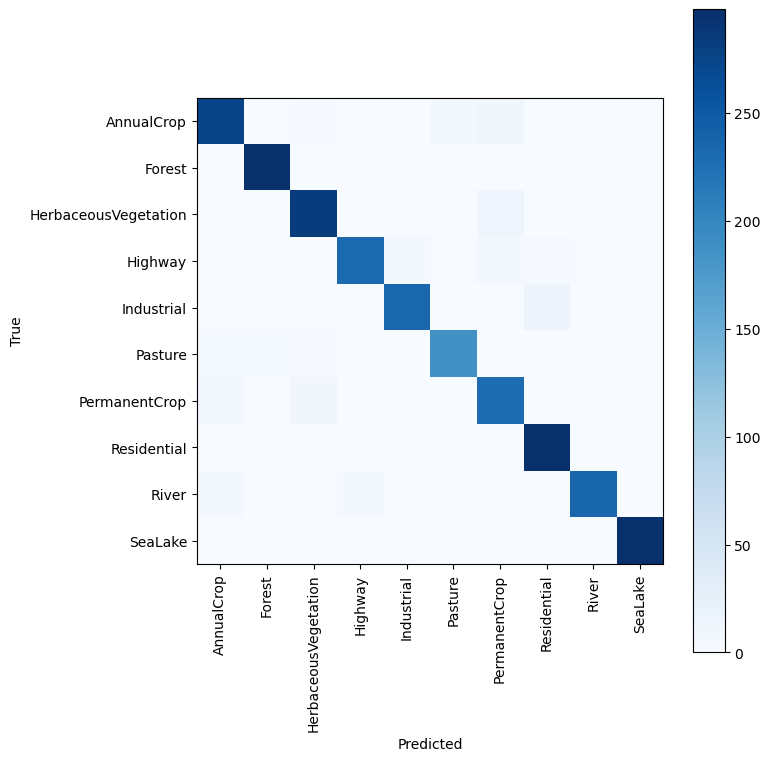


>>> Final Test Accuracy:
  Overall:              95.0%
  Weighted class acc.:  95.0%

Class                    Acc   Train+Val     Test
-------------------------------------------------
AnnualCrop              91.7%         11%       11%
Forest                  98.7%         11%       11%
HerbaceousVegetation    94.7%         11%       11%
Highway                 92.4%          9%        9%
Industrial              93.6%          9%        9%
Pasture                 93.5%          7%        7%
PermanentCrop           90.8%          9%        9%
Residential             99.0%         11%       11%
River                   94.4%          9%        9%
SeaLake                 99.3%         11%       11%


final_test_acc,▁
weighted_class_acc,▁
final_test_acc,95
weighted_class_acc,95


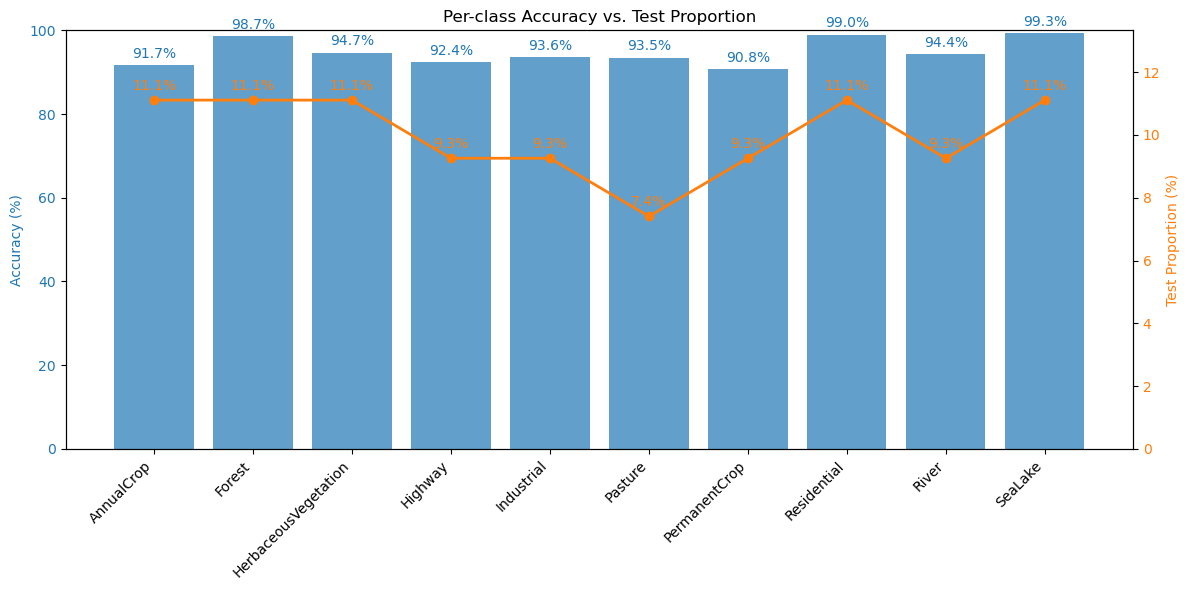

In [7]:


final_test_acc, acc_per_class, all_labels, all_preds = evaluate(final_model, te_dl, n_cls)
plot_confusion_matrix_from_preds(all_labels, all_preds, te_dl.dataset.dataset.classes)

test_targets = np.array(te_dl.dataset.dataset.targets)[te_dl.dataset.indices]
class_proportions_test = np.bincount(test_targets, minlength=n_cls) / len(test_targets)

combined_targets = np.concatenate([
    np.array(sub.dataset.targets)[sub.indices]
    for sub in combined_dataset.datasets
])
class_proportion_train_val = np.bincount(combined_targets, minlength=n_cls) / len(combined_targets)

acc_vals = np.array([acc_per_class[c] for c in range(n_cls)])
weighted_class_acc = (acc_vals * class_proportions_test).sum()

print("\n>>> Final Test Accuracy:")
print(f"  Overall:             {final_test_acc:5.1f}%")
print(f"  Weighted class acc.: {weighted_class_acc:5.1f}%\n")

hdr = f"{'Class':20s}  {'Acc':>6s}   {'Train+Val':>9s}   {'Test':>6s}"
print(hdr)
print("-" * len(hdr))

for c, name in enumerate(te_dl.dataset.dataset.classes):
    acc  = acc_vals[c]
    p_tr = class_proportion_train_val[c] * 100
    p_te = class_proportions_test[c]    * 100
    print(f"{name:20s}  {acc:6.1f}%   {p_tr:8.0f}%   {p_te:6.0f}%")

wandb.init(
    project="eurosat-supervised-scratch-final",
    name=f"BS{bs}_LR{lr:.0e}_final",
    config={
        "batch_size":     bs,
        "learning_rate":  lr,
        "epochs":         NUM_EPOCHS,
        "pretrained":     False,
        "final_retrain":  True
    }
)
wandb.log({
    "final_test_acc":      final_test_acc,
    "weighted_class_acc":  weighted_class_acc,
    "per_class_acc":       acc_vals
})
wandb.finish()

plot_class_acc_prop()